In [385]:
import os
import sys
import pandas as pd
from copy import copy


data_path = os.path.join(os.getcwd(), '../data')
src_path = os.path.join(os.getcwd(), '../src')
sys.path.append(src_path)

import utils

In [386]:
df = pd.read_csv(os.path.join(data_path, 'data.csv'), index_col='Municipality')

## Duplicated Columns

In [387]:
def getDuplicateColumns(df):
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicated_columns = getDuplicateColumns(df)

In [388]:
df.drop(columns=duplicated_columns, inplace=True)

In [389]:
not_div_cols = list(df.filter(regex=r'density|education|per_capita|municipal_waste|^(?!.*surface).*territory.*$|(?=.*growth)(?=.*average)|turnout|rate').columns)

In [390]:
df['population_population_by_sex_total'].isna().sum()

0

In [391]:
not_div_cols.append('population_population_by_sex_total')
cols = df.loc[:, ~df.columns.isin(not_div_cols)].select_dtypes(include='number').columns
df[cols] = df.loc[:, ~df.columns.isin(not_div_cols)].select_dtypes(include='number').div(df['population_population_by_sex_total'], axis=0)

## Numerical Missing Values

In [392]:
percent_missing = df.isnull().sum() / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing}).reset_index(drop=True).iloc[1:, :]
missing_value_df_copy = copy(missing_value_df)
missing_value_df.describe()

,percent_missing
count,205.000000
mean,0.231577
std,0.343363
min,0.000000
25%,0.000000
50%,0.002022
75%,0.496461
max,0.986855


In [393]:
missing_value_df.head()

,column_name,percent_missing
1,territory__altitude,0.042467
2,territory__longitude,0.042467
3,territory__latitude,0.042467
4,territory__geographic_indicators_utm_coordinat...,0.042467
5,territory__geographic_indicators_utm_coordinat...,0.042467


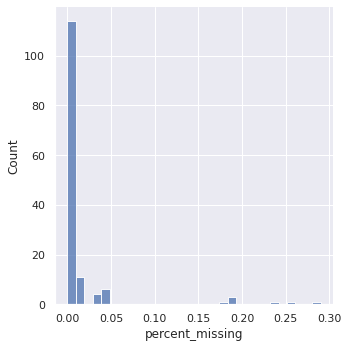

In [394]:
import seaborn as sns

missing_value_df = missing_value_df_copy[missing_value_df_copy['percent_missing'] < 0.3]

sns.set_theme()
sns.displot(missing_value_df, x='percent_missing', bins=30)

In [395]:
# Filter main df by removing columns with too many missing values
print(df.shape)
filtered_columns = missing_value_df['column_name'].to_numpy()
df = df[filtered_columns]
print(df.shape)

(989, 206)
(989, 142)


In [396]:
# pd.set_option('display.max_rows', 999)
# pd.set_option('display.max_columns', 999)
# pd.set_option('display.max_colwidth', 20)

# missing_value_df.sort_values(['percent_missing'], ascending=False).style.set_properties(**{'text-align': 'left'})

In [397]:
# Store how many missing values has the row before imputation to check for later outliers
missing_track = df.apply(lambda x: x.isna().sum(), axis=1)
missing_track.describe()

count    989.000000
mean       2.132457
std        2.423662
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       31.000000
dtype: float64

In [398]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

simple_imputer = SimpleImputer()
simple_data = copy(df.select_dtypes(include='number'))
simple_data[:] = simple_imputer.fit_transform(simple_data)

In [399]:
from scipy.stats import ks_2samp

def check_distributions(df1, df2, printit=True, badcols=False):
    
    pvalue = 0
    n = 0
    bad_cols = []
    for col in df2.columns:
        ks = ks_2samp(df1[col].dropna(), df2[col])
        pvalue += ks.pvalue
        
        if ks.pvalue < 0.05: 
            n += 1 
            if printit: 
                bad_cols.append(col)
                print(col, df1[col].isna().sum())
    
    avg_pvalue = pvalue/len(df1.columns)
    if badcols:
        return bad_cols
    return avg_pvalue, n

check_distributions(df.select_dtypes(include='number'), simple_data, printit=False)

(0.9450876233239034, 7)

In [400]:
for k in range(1,10):
    knn_imputer = KNNImputer(n_neighbors=k, weights='distance')
    knn_data = copy(df.select_dtypes(include='number'))
    knn_data[:] = knn_imputer.fit_transform(knn_data)
    print(f'K: {k}', check_distributions(df.select_dtypes(include='number'), knn_data, printit=False))

K: 1 (0.9543646957639171, 5)
K: 2 (0.9571135561655777, 5)
K: 3 (0.9562938782404148, 6)
K: 4 (0.9548957343048908, 5)
K: 5 (0.9537611073310798, 6)
K: 6 (0.9527636441281925, 6)
K: 7 (0.9519365132826436, 6)
K: 8 (0.9518445923069393, 6)
K: 9 (0.9512100787107867, 6)


In [401]:
# Best imputer
knn_imputer = KNNImputer(n_neighbors=2, weights='distance')
imputed_data = copy(df.select_dtypes(include='number'))
imputed_data[:] = knn_imputer.fit_transform(imputed_data)
bad_cols = check_distributions(df.select_dtypes(include='number'), imputed_data, badcols=True)

elections_municipal_elections_electors 186
labour_affiliations_to_general_system_according_to_location_of_affilation_by_sectors_construction 287
labour_affiliations_to_self_employed_system_according_to_location_of_affilation_by_sectors_agriculture 185
quality_of_life_type_of_dwellings_vacant 256
quality_of_life_type_of_dwellings_secondary 237


In [402]:
df.loc[:, imputed_data.columns] = imputed_data
df.drop(columns=bad_cols, inplace=True)

## Categorical Missing Values

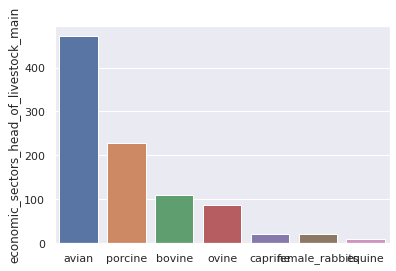

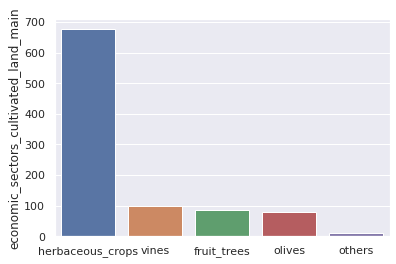

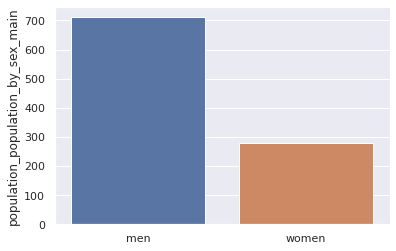

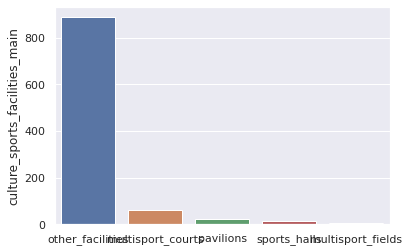

In [403]:
import matplotlib.pyplot as plt

for cat in df.select_dtypes(exclude='number').columns:
    aux = df[cat].value_counts()
    sns.barplot(x=aux.index, y=aux)
    plt.show()

In [404]:
df.select_dtypes(exclude='number').isna().sum()

economic_sectors_head_of_livestock_main    38
economic_sectors_cultivated_land_main      38
population_population_by_sex_main           0
culture_sports_facilities_main              0
dtype: int64

In [405]:
df = df.apply(lambda x: x.fillna('Unknown'))

In [406]:
df['missing_count'] = missing_track

## Outliers - Mahalanobis Distance

In [407]:
import numpy as np

num_df = copy(df.select_dtypes(include='number'))
covariance = np.cov(num_df, rowvar=False)
sum(sum(pd.isna(covariance))) # Issues with covariance due to high correlations

0

In [408]:
covariance_pm1 = np.linalg.matrix_power(covariance, -1)
centerpoint = np.mean(num_df, axis=0)

In [409]:
from scipy.stats import chi2
from scipy.spatial.distance import mahalanobis

distances = []
for i in range(len(num_df)):
      p1 = num_df.iloc[i,:]
      p2 = centerpoint
      # distance = mahalanobis(p1, p2, covariance_pm1)
      distance = (p1-p2).T.dot(covariance_pm1).dot(p1-p2)
      distances.append(distance)
distances = np.array(distances)

# Cutoff (threshold) value from Chi-Sqaure Distribution for detecting outliers 
cutoff = chi2.ppf(0.99, num_df.shape[1])

# # Index of outliers
outlierIndexes = np.where(distances > cutoff )

print('--- Index of Outliers ----')
print(len(outlierIndexes[0]))

--- Index of Outliers ----
260


## Model Based

In [410]:
from sklearn.ensemble import IsolationForest

num_df = copy(df.select_dtypes(include='number'))

#create the method instance
isf = IsolationForest(n_estimators = 100, random_state = 42, contamination = 'auto')

#use fit_predict on the data as we are using all the data
preds = isf.fit_predict(num_df)

# #extract outliers from the data
num_df["iso_forest_outliers"] = preds
num_df["iso_forest_outliers"] = num_df["iso_forest_outliers"].astype(str)

print(num_df.shape[1])

# #extract the scores from the data in terms of strength of outlier
num_df["iso_forest_scores"] = isf.decision_function(num_df.drop(columns='iso_forest_outliers')) #print how many outliers the data suggests
print(num_df["iso_forest_outliers"].value_counts())

135
1     962
-1     27
Name: iso_forest_outliers, dtype: int64


In [411]:
outlier_ix = num_df[num_df['iso_forest_outliers'] == '-1'].index
nonoutlier_ix = num_df[num_df['iso_forest_outliers'] == '1'].index
num_df.loc[outlier_ix, 'missing_count'].describe()

count    27.000000
mean      7.333333
std       5.114083
min       1.000000
25%       3.000000
50%       7.000000
75%      10.500000
max      19.000000
Name: missing_count, dtype: float64

In [412]:
num_df.loc[nonoutlier_ix, 'missing_count'].describe()

count    962.000000
mean       1.986486
std        2.133140
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       31.000000
Name: missing_count, dtype: float64

In [413]:
clean_data = df.loc[nonoutlier_ix, :]
outlier_data = df.loc[outlier_ix, :]

clean_data.to_csv('../data/clean_data.csv')
outlier_data.to_csv('../data/outlier_data.csv')

## Feature Extraction (not yet)

In [191]:
pd.DataFrame({'column_name': clean_data.columns}).style.set_properties(**{'text-align': 'left'})

,column_name
0,territory__altitude
1,territory__longitude
2,territory__latitude
3,territory__geographic_indicators_utm_coordinates_x_utm_coordinates_x
4,territory__geographic_indicators_utm_coordinates_y_utm_coordinates_y
5,population_density_of_population_density_density
6,population_population_by_sex_men
7,population_population_by_sex_women
8,population_population_by_sex_total
9,population_population_by_age_groups_from_0_to_14_years
